# Karjääri alanduslehtri arvutus Marinelli ja Niccoli 2000 alusel

In [1]:
# Vajalikud Pythoni lisamoodulid
from math import sqrt, pi, log, log10, floor
import numbers

import pandas as pd
from scipy import optimize
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.transforms import blended_transform_factory
import seaborn as sns

sns.set_style("darkgrid")

Meetodi allikas: https://doi.org/10.1111/j.1745-6584.2000.tb00342.x

Visuaalne mudel:

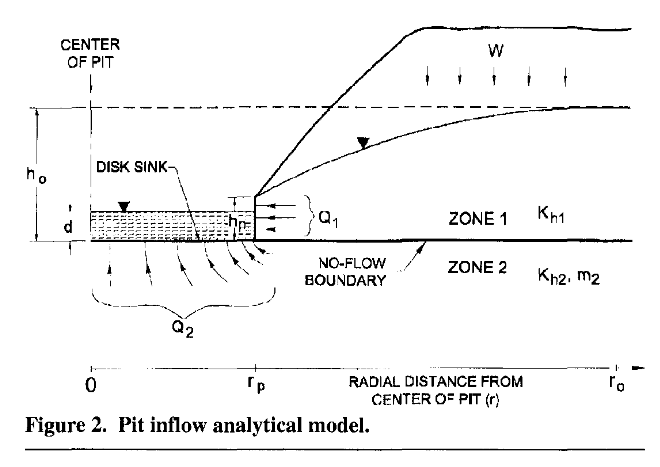

Leidmaks stabiliseerunud alanduslehtri raadiust tsoonis 1 (karjääri põhja tasemest
kõrgemal), pead iteratiivselt leidma vastavas valemis $r_0$:

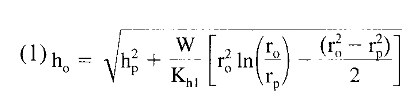,

kus
* $W$ on infiltratsioon (m/s),
* $K_{hl}$ on horisontaalne filtratsioonimoodul (m/s) -- omab suurimat mõju arvutusele,
* $r_p$ on karjääri efektiivne raadius (m) -- $\sqrt{S/\pi}$,
* $h_p$ on veest küllastunud tsooni kõrgus karjääri seinal (m) -- pruugib olla veetaseme
  sügavus karjääris, mis võrdub nulliga, kui karjääri hoitakse tühjana, või kõrgem,
* $r_0$ on karjääri mõjuraadius (m),
* $h_0$ on veetaseme kõrgus karjääri põhjast alates enne kaevandamise algust (m).

Leidmaks abs veetaset konkreetsel kaugusel karjääri keskpunktist, saad kasutada valemit

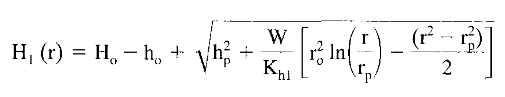,

kus
* $H_0$ on abs veetase enne kaevandamist (m),
* $H_1$ on abs veetase uuritaval kaugusel (m),
* $r$ on radiaalne kaugus karjääri keskmest (m).


## Eeldused

* Karjäär on silindrilise kujuga. Seega väga ebakorrapärase karjääri puhul tasub mängida
    efektiivse raadiusega $r_p$, et hinnata selle mõju. Kui mõju on suur, siis tuleb
    nentida suurt veapiiri.
* Veevool on horisontaalne. Üldjuhul okei eeldus, aga vertikaalse voolukomponendi juures
    tulevad valemisse olulised vead, eriti kui vertikaalne vool toimub väga karjääri
    lähedal.
* Algne veetase on horisontaalne. See ei ole kunagi täpselt tõsi, aga kui veetaseme
    gradient on väike, ei ole hullu. Parandamiseks võib kasutada lähendust

    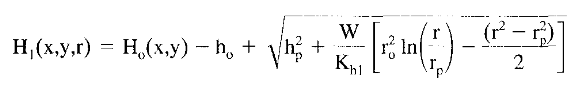

    kus $H_0(x,y)$ on algne abs veetase uuritavas kohas ja $H_1(x,y,r)$ on otsitav abs
    veetase. Lähendus muutub seda ebatäpsemaks, mida suurem on gradient.
* Infiltratsioon on ühtlane ja kõik alanduslehtris toimuv infiltratsioon jõuab karjääri.
    Kui karjääri ümbruse mikrokliima, taimestik või pinnas erineb oluliselt sademete ja
    infiltratsiooni määra mõõtekoha omast, siis võib valesti valitd $W$ viga suurendada.
* Veevool karjääri on sümmeetriline. Problemaatiline, kui karjääri ümbruses esineb
    muutusi litoloogias, karsti, lõhelisust või kui vesi juhitakse ära kraavidega.

Konkreetne arvutus eeldab ka, et tsoonist 2 (karjääri põhjatasemest madalamal) ei toimu
olulist sissevoolu.

## Arvutuskäikude definitsioonid

In [2]:
def calculate_precipitation(
    *sheets,
    year_cutoff_pre=0,
    header=2,
    precipitation_col="Tunni sademete summa mm",
    year_col="Aasta",
    output_unit="m/s",
):
    """Get precipitation from Estonian Weather Service historical data spreadsheets."""
    dfs = [pd.read_excel(sheet, header=header) for sheet in sheets]
    df = pd.concat(dfs)
    filtered_df = df[df[year_col] > year_cutoff_pre]
    precipitation_total = filtered_df[precipitation_col].sum()
    precipitation_mm_per_hour = precipitation_total / filtered_df.shape[0]

    if output_unit == "m/s":
        return precipitation_mm_per_hour / 60 / 60 / 1000
    elif output_unit == "m/d":
        return precipitation_mm_per_hour * 24 / 1000
    elif output_unit == "mm/y":
        return precipitation_mm_per_hour * 24 * 365.25
    else:
        raise ValueError("`output_unit` must be 'm/s', 'm/d', or 'mm/y'")


def get_infiltration(precipitation, infiltration_coefficient):
    """Return infiltration from precipitation and infiltration coefficient."""
    return precipitation * infiltration_coefficient


def get_effective_radius(quarry_area):
    """Return ideal circularized radius from true quarry area."""
    return sqrt(quarry_area / pi)


def get_watertable_height(volume_underwater, quarry_area):
    """Get initial watertable height if you have underwater rock volume and quarry
    area."""
    return volume_underwater / quarry_area


def convert_transmissivity_to_m_per_sec(transmissivity_m_per_day):
    """Unit conversion of transmissivity from m/d to m/s."""
    return transmissivity_m_per_day / (24 * 60 * 60)


def get_marinelli_niccoli_h_0(r_0, h_0, h_p, W, K_h, r_p):
    """Marinelli and Niccoli 2000 formula describing horizontal groundwater flow into
    pit. r_0 will be correct if return value is 0."""
    radius_term = r_0**2 * log(r_0 / r_p) - (r_0**2 - r_p**2) / 2
    right_term = sqrt(h_p**2 + (W / K_h) * radius_term)
    return h_0 - right_term


def get_depression_radii(h_0, h_p, W, K_h, r_p, r_0_initial=10000):
    """Find optimum depression radii through Marinelli and Niccoli 2000 formula."""
    r_0 = optimize.fsolve(
        func=get_marinelli_niccoli_h_0, x0=r_0_initial, args=(h_0, h_p, W, K_h, r_p)
    )[0]
    radius_from_wall = r_0 - r_p
    return r_0, radius_from_wall


# Visualiseerimine
def draw_Marinelli_Niccoli_radius_optimization(h_0, h_p, W, K_h, r_p, x_tail_coef=2):
    """Visualize the optimal parameter found during Marinelli Niccoli 2000 r_0
    optimization."""
    chosen_r0, _ = get_depression_radii(h_0=h_0, h_p=h_p, W=W, K_h=K_h, r_p=r_p)
    r0_arr = np.linspace(1, chosen_r0 * x_tail_coef, 1000)
    func_arr = np.vectorize(get_marinelli_niccoli_h_0)(
        r0_arr, h_0=h_0, h_p=h_p, W=W, K_h=K_h, r_p=r_p
    )
    _, opt_ax = plt.subplots()
    opt_ax.plot(r0_arr, func_arr)
    opt_ax.set_ylabel("Valemi kaugus tasakaalust")
    opt_ax.set_xlabel("Alanduslehtri ulatus karjääri keskpunktist ($r_0$)")
    opt_ax.axhline(0, color=".2", linewidth=0.6, linestyle="--")
    opt_ax.axvline(chosen_r0, color="red", linewidth=0.6, linestyle="dashdot")

    text_pad = (opt_ax.get_xlim()[1] - opt_ax.get_xlim()[0]) * 0.0013
    opt_ax.text(
        chosen_r0 - text_pad,
        0.05,
        "Valitud $r_0$",
        rotation=90,
        color="C3",
        ha="right",
        va="bottom",
        transform=blended_transform_factory(opt_ax.transData, opt_ax.transAxes),
    )
    opt_ax.set_title("Marinelli & Niccoli valemi tasakaalupunkti leidmine (0 on hea)")


def get_depression_at_r(radius_from_wall, r_0, h_0, h_p, W, K_h, r_p):
    """Return depression at length `radius_from_wall` according to Marinelli & Niccoli
    (2000)."""
    if radius_from_wall < 0:
        return -h_0
    elif radius_from_wall > r_0 - r_p:
        return 0
    else:
        radius = radius_from_wall + r_p
        radius_term = r_0**2 * log(radius / r_p) - (radius**2 - r_p**2) / 2
        sqrt_term = sqrt(h_p**2 + (W / K_h) * radius_term)
        return sqrt_term - h_0


def balance_depression_threshold(
    radius_from_wall, r_0, h_0, h_p, W, K_h, r_p, threshold=1
):
    """Helper function to find radius where depression is at threshold."""
    return get_depression_at_r(radius_from_wall, r_0, h_0, h_p, W, K_h, r_p) + threshold


def get_significant_radius(r_0, h_0, h_p, W, K_h, r_p, significant_threshold=1):
    """Return radius at which depression equals given threshold (default = 1 m)."""
    return optimize.fsolve(
        func=balance_depression_threshold,
        x0=10,
        args=(r_0, h_0, h_p, W, K_h, r_p, significant_threshold),
    )[0]


def draw_depression_curve(
    ax, r_0, h_0, h_p, W, K_h, r_p, line_buffer=1.5, lims=None, **kwargs
):
    """Draw the depression curve on the specified matplotlib axes."""
    r_from_wall = r_0 - r_p
    if not lims:
        lims = (-(r_from_wall * line_buffer / 10), r_from_wall * line_buffer)
    radius_arr = np.linspace(*lims, 1000)
    profile_arr = [
        get_depression_at_r(x, r_0, h_0, h_p, W, K_h, r_p) for x in radius_arr
    ]
    return ax.plot(radius_arr, profile_arr, **kwargs)


def draw_depression_figure(
    r_0,
    h_0,
    h_p,
    W,
    K_h,
    r_p,
    lims=None,
    title=None,
    show_significant_radius=True,
    show_full_radius=True,
    line_kwargs=dict(),
    fig_kwargs=dict(figsize=(10, 6)),
    span_kwargs=dict(color="C1", alpha=0.1),
    radiusline_kwargs=dict(color=".2", linewidth="0.6", linestyle="--"),
    radiustext_kwargs=dict(color=".2"),
    axvlines=dict(),
    axvline_kwargs=dict(color="red", linewidth="0.6", linestyle="dashdot"),
    axlinetext_kwargs=dict(color="C3"),
    linetext_buffer=0.002,
):
    if not title:
        K_m_per_day = K_h * 60 * 60 * 24
        title = f"Põhjaveetaseme alanduslehtri külgprofiil (Marinelli ja Niccoli 2000)"
        title += f"\nfiltratsioonimoodul = {K_m_per_day:.1f} m/p"

    fig, ax = plt.subplots(**fig_kwargs)
    draw_depression_curve(ax, r_0, h_0, h_p, W, K_h, r_p, lims=lims, **line_kwargs)
    ax.set_xlim(*ax.get_xlim())
    ax.axvspan(ax.get_xlim()[0], 0, **span_kwargs)
    ax.text(
        (ax.get_xlim()[0]) / 2,
        0.98,
        "Karjäär",
        ha="center",
        va="top",
        transform=blended_transform_factory(ax.transData, ax.transAxes),
    )

    linetext_pad = (ax.get_xlim()[1] - ax.get_xlim()[0]) * linetext_buffer
    if show_significant_radius:
        significant_radius = get_significant_radius(r_0, h_0, h_p, W, K_h, r_p)
        ax.axvline(significant_radius, **radiusline_kwargs)
        ax.text(
            significant_radius - linetext_pad,
            0.02,
            f"Olulise mõju piir (alandus > 1 m) = {significant_radius:.0f} m",
            transform=blended_transform_factory(ax.transData, ax.transAxes),
            rotation=90,
            ha="right",
            va="bottom",
            **radiustext_kwargs,
        )

    if show_full_radius:
        full_radius = r_0 - r_p
        ax.axvline(full_radius, **radiusline_kwargs)
        ax.text(
            full_radius - linetext_pad,
            0.02,
            f"Alanduslehtri ulatus (alandus > 0) = {full_radius:.0f} m",
            transform=blended_transform_factory(ax.transData, ax.transAxes),
            rotation=90,
            ha="right",
            va="bottom",
            **radiustext_kwargs,
        )

    for name, loc in axvlines.items():
        ax.axvline(loc, **axvline_kwargs)
        ax.text(
            loc - linetext_pad,
            0.02,
            name,
            rotation=90,
            ha="right",
            va="bottom",
            transform=blended_transform_factory(ax.transData, ax.transAxes),
            **axlinetext_kwargs,
        )

    ax.set_ylabel("Veetaseme alandus (m)")
    ax.set_xlabel("Kaugus karjääri servast (m)")
    ax.set_title(title)

    return fig


def get_zone1_inflow(W, r_0, r_p):
    """Inflow for zone 1 (pit walls)."""
    return W * pi * (r_0**2 - r_p**2)


def get_zone2_inflow(r_p, K_h, anisotropy, h_0, d):
    """Inflow for zone 2 (pit bottom)."""
    anisotropy_term = sqrt(K_h / (K_h * anisotropy))
    return 4 * r_p * (K_h / anisotropy_term) * (h_0 - d)


def draw_multiple_depressions(
    h0_arr, h_p, W, K_h, r_p, title, lims, show_full=True, show_significant=False
):
    r0_arr = [
        get_depression_radii(h_0=h0, h_p=h_p, W=W, K_h=K_h, r_p=r_p)[0] for h0 in h0_arr
    ]
    rsig_arr = [
        get_significant_radius(r0, h0, h_p, W, K_h, r_p)
        for r0, h0 in zip(r0_arr, h0_arr)
    ]
    fig = draw_depression_figure(
        r_0=r0_arr[0],
        h_0=h0_arr[0],
        h_p=h_p,
        W=W,
        K_h=K_h,
        r_p=r_p,
        show_full_radius=False,
        show_significant_radius=False,
        lims=lims,
        title=title,
    )
    ax = fig.axes[0]
    if show_full:
        ax.axvline(r0_arr[0] - r_p, ls="--", lw=0.6, color="C0")
        ax.text(
            r0_arr[0] - r_p,
            0.01,
            f"Alanduslehtri ulatus alandusel {h0_arr[0]} m = {r0_arr[0] - r_p:.0f} m",
            rotation=90,
            va="bottom",
            ha="right",
            transform=blended_transform_factory(ax.transData, ax.transAxes),
        )
    if show_significant:
        ax.axvline(rsig_arr[0], ls=":", lw=0.6, color="C0")
        ax.text(
            rsig_arr[0],
            0.01,
            f"Olulise mõju piir alandusel {h0_arr[0]} m = {rsig_arr[0]:.0f} m",
            transform=blended_transform_factory(ax.transData, ax.transAxes),
            rotation=90,
            ha="right",
            va="bottom",
        )

    for r0, h0, rsig, color in zip(
        r0_arr[1:], h0_arr[1:], rsig_arr[1:], ["C1", "C2", "C3"]
    ):
        draw_depression_curve(
            ax, r_0=r0, h_0=h0, h_p=h_p, W=W, K_h=K_h, r_p=r_p, lims=lims
        )
        if show_full:
            ax.axvline(r0 - r_p, color=color, ls="--", lw=0.6)
            ax.text(
                r0 - r_p,
                0.01,
                f"Alanduslehtri ulatus alandusel {h0} m = {r0 - r_p:.0f} m",
                rotation=90,
                va="bottom",
                ha="right",
                transform=blended_transform_factory(ax.transData, ax.transAxes),
            )
        if show_significant:
            ax.axvline(rsig, ls=":", lw=0.6, color=color)
            ax.text(
                rsig,
                0.01,
                f"Olulise mõju piir alandusel {h0} m = {rsig:.0f} m",
                transform=blended_transform_factory(ax.transData, ax.transAxes),
                rotation=90,
                ha="right",
                va="bottom",
            )

    return fig


def add_full_params(site_dict, precip_cutoff=2010):
    if isinstance(site_dict["precip_input"], numbers.Real):
        # Assume mm/y as input, but we need m/s
        precipitation = site_dict["precip_input"] / (1000 * 365.25 * 24 * 60 * 60)
    else:
        precipitation = calculate_precipitation(
            site_dict["precip_input"], year_cutoff_pre=precip_cutoff
        )
    site_dict["W"] = get_infiltration(precipitation, site_dict["inf_coef"])
    site_dict["K_h"] = convert_transmissivity_to_m_per_sec(site_dict["trans_m_d"])
    site_dict["r_p"] = get_effective_radius(site_dict["area_effective"])


def round_to_n(x, n):
    try:
        round_digits = -int(floor(log10(x))) + (n - 1)
    except ValueError:
        try:
            round_digits = -int(floor(log10(-x))) + (n - 1)
        except ValueError:
            return 2
    return round(x, round_digits)

## Algparameetrid

In [3]:
h0_arr = [6, 8]
sites = {
    "Koonga": dict(
        h_p=0,
        precip_input=761,
        inf_coef=0.1,
        area_effective=40 * 100,
        trans_m_d=20,
        lims=(-100, 1500),
    ),
}

## Arvutuse teostamine

In [4]:
for site in sites.values():
    add_full_params(site)
print(pd.DataFrame(sites.values()))


   h_p  precip_input  inf_coef  area_effective  trans_m_d          lims  \
0    0           761       0.1            4000         20  (-100, 1500)   

              W       K_h        r_p  
0  2.411463e-09  0.000231  35.682482  


In [5]:
# Temporary override to account for spring melt.
#sites["Järavere"]['W'] = 160 / (14 * 24 * 60 * 60)
#sites["Järavere"]

/tmp/ipykernel_366486/4127475964.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  radius_term = r_0**2 * log(r_0 / r_p) - (r_0**2 - r_p**2) / 2
/tmp/ipykernel_366486/4127475964.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  right_term = sqrt(h_p**2 + (W / K_h) * radius_term)
/tmp/ipykernel_366486/4127475964.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  radius_term = r_0**2 * log(radius / r_p) - (radius**2 - r_p**2) / 2
/tmp/ipykernel_366486/412747

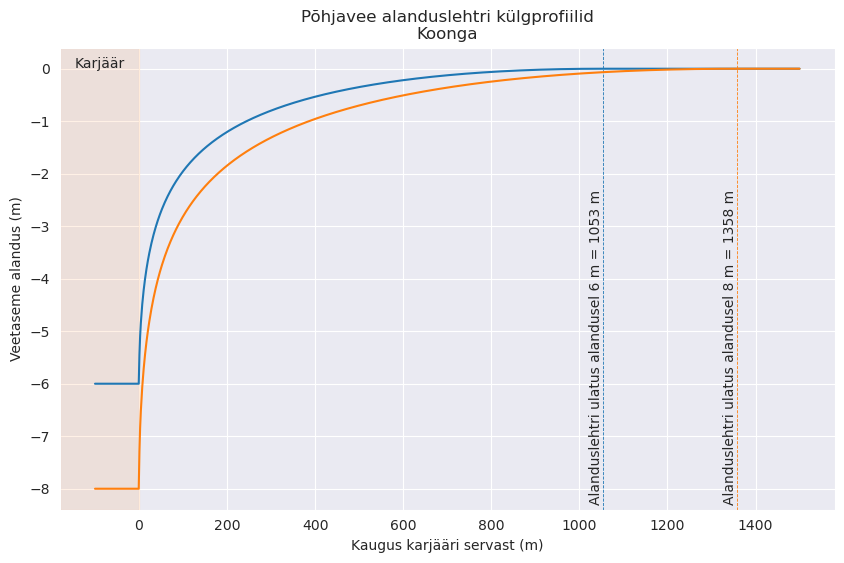

In [6]:
for name, site in sites.items():
    fig = draw_multiple_depressions(
        h0_arr=h0_arr,
        h_p=site["h_p"],
        W=site["W"],
        K_h=site["K_h"],
        r_p=site["r_p"],
        title=f"Põhjavee alanduslehtri külgprofiilid\n{name}",
        lims=site["lims"],
        show_full=True,
        show_significant=False,
    )
    #fig.savefig(f"{name} alanduslehtrid.png")

In [7]:
tables = []
for name, site in sites.items():
    inflows1 = []
    inflows2 = []
    depression_radii = []
    depression_radii_from_wall = []
    significant_radii = []
    depression_at_100 = []
    depression_at_300 = []
    depression_at_500 = []
    depression_at_1000 = []
    depression_at_1500 = []
    depression_at_2000 = []
    depression_at_2500 = []
    for h0 in h0_arr:
        r0, r0_from_wall = get_depression_radii(
            h_0=h0, h_p=site["h_p"], W=site["W"], K_h=site["K_h"], r_p=site["r_p"]
        )
        depression_radii.append(r0)
        depression_radii_from_wall.append(r0_from_wall)

        sigrad = get_significant_radius(
            r_0=r0,
            h_0=h0,
            h_p=site["h_p"],
            W=site["W"],
            K_h=site["K_h"],
            r_p=site["r_p"],
        )
        significant_radii.append(sigrad)

        depression_at_100.append(
            abs(
                get_depression_at_r(
                    100, r0, h0, site["h_p"], site["W"], site["K_h"], site["r_p"]
                )
            )
        )
        depression_at_300.append(
            abs(
                get_depression_at_r(
                    300, r0, h0, site["h_p"], site["W"], site["K_h"], site["r_p"]
                )
            )
        )
        depression_at_500.append(
            abs(
                get_depression_at_r(
                    500, r0, h0, site["h_p"], site["W"], site["K_h"], site["r_p"]
                )
            )
        )
        depression_at_1000.append(
            abs(
                get_depression_at_r(
                    1000, r0, h0, site["h_p"], site["W"], site["K_h"], site["r_p"]
                )
            )
        )
        depression_at_1500.append(
            abs(
                get_depression_at_r(
                    1500, r0, h0, site["h_p"], site["W"], site["K_h"], site["r_p"]
                )
            )
        )
        depression_at_2000.append(
            abs(
                get_depression_at_r(
                    2000, r0, h0, site["h_p"], site["W"], site["K_h"], site["r_p"]
                )
            )
        )
        depression_at_2500.append(
            abs(
                get_depression_at_r(
                    2500, r0, h0, site["h_p"], site["W"], site["K_h"], site["r_p"]
                )
            )
        )

        inflows1.append(get_zone1_inflow(site["W"], r0, site["r_p"]))
        inflows2.append(
            get_zone2_inflow(
                r_p=site["r_p"], K_h=site["K_h"], anisotropy=0.1, h_0=h0, d=0
            )
        )
    inflowtable = pd.DataFrame(
        {
            "Uuringuala": name.split(" ")[0],
            "Filtratsioonimoodul (m/p)": site["trans_m_d"],
            "Alandus (m)": h0_arr,
            "Alanduslehtri ulatus karjääri keskpunktist (m)": depression_radii,
            "Alanduslehtri ulatus karjääri servast (m)": depression_radii_from_wall,
            "Alandus 100 m kaugusel (m)": depression_at_100,
            "Alandus 300 m kaugusel (m)": depression_at_300,
            "Alandus 500 m kaugusel (m)": depression_at_500,
            "Alandus 1000 m kaugusel (m)": depression_at_1000,
            "Alandus 1500 m kaugusel (m)": depression_at_1500,
            "Alandus 2000 m kaugusel (m)": depression_at_2000,
            "Alandus 2500 m kaugusel (m)": depression_at_2500,
            "Olulise alanduse ulatus karjääri servast (m)": significant_radii,
            "Sissevool küljelt (m3/s)": inflows1,
            "Sissevool põhjast (m3/s)": inflows2,
        }
    )
    inflowtable["Kogu sissevool (m3/s)"] = (
        inflowtable["Sissevool küljelt (m3/s)"]
        + inflowtable["Sissevool põhjast (m3/s)"]
    )
    inflowtable["Kogu sissevool (m3/a)"] = (
        inflowtable["Kogu sissevool (m3/s)"] * 60 * 60 * 24 * 365.25
    )
    inflowtable["Sademete sissevool (m3/s)"] = site["W"] * site["area_effective"]
    # override for spring melt
    #inflowtable["Sademete sissevool (m3/s)"] = (726 * 0.4 / (1000 * 365.25 * 24 * 60 * 60) + 160 / (1000 * 14 * 24 * 60 * 60)) * site["area_effective"]
    inflowtable["Sissevool külg ja sademed (m3/s)"] = (
        inflowtable["Sademete sissevool (m3/s)"]
        + inflowtable["Sissevool küljelt (m3/s)"]
    )
    inflowtable["Sissevool külg ja sademed (m3/a)"] = inflowtable["Sissevool külg ja sademed (m3/s)"] * 60 * 60 * 24 * 365.25
    tables.append(inflowtable)

#pd.concat(tables).to_excel("veealanduse_tulemused.xlsx")
pd.concat(tables)

/tmp/ipykernel_366486/4127475964.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  radius_term = r_0**2 * log(r_0 / r_p) - (r_0**2 - r_p**2) / 2
/tmp/ipykernel_366486/4127475964.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  right_term = sqrt(h_p**2 + (W / K_h) * radius_term)
/tmp/ipykernel_366486/4127475964.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  radius_term = r_0**2 * log(radius / r_p) - (radius**2 - r_p**2) / 2
/tmp/ipykernel_366486/412747

,Uuringuala,Filtratsioonimoodul (m/p),Alandus (m),Alanduslehtri ulatus karjääri keskpunktist (m),Alanduslehtri ulatus karjääri servast (m),Alandus 100 m kaugusel (m),Alandus 300 m kaugusel (m),Alandus 500 m kaugusel (m),Alandus 1000 m kaugusel (m),Alandus 1500 m kaugusel (m),Alandus 2000 m kaugusel (m),Alandus 2500 m kaugusel (m),Olulise alanduse ulatus karjääri servast (m),Sissevool küljelt (m3/s),Sissevool põhjast (m3/s),Kogu sissevool (m3/s),Kogu sissevool (m3/a),Sademete sissevool (m3/s),Sissevool külg ja sademed (m3/s),Sissevool külg ja sademed (m3/a)
0,Koonga,20,6,1088.212649,1052.530167,1.951781,0.796921,0.349330,0.002436,0,0,0,244.000377,0.008962,0.062688,0.071649,2.261084e+06,0.00001,0.008971,283114.471424
1,Koonga,20,8,1393.215564,1357.533082,2.811650,1.310828,0.700134,0.092614,0,0,0,385.589634,0.014695,0.083584,0.098279,3.101452e+06,0.00001,0.014705,464056.825109
